C:\Users\santi\AppData\Local\Temp\ipykernel_24920\933174694.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_population = pd.read_sql("SELECT * FROM population", con=connection)
C:\Users\santi\AppData\Local\Temp\ipykernel_24920\933174694.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_birth = pd.read_sql("SELECT * FROM birth_rate", con=connection)
C:\Users\santi\AppData\Local\Temp\ipykernel_24920\933174694.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fertility = pd.read_sql("SELECT * FROM fertility

MÉTRICAS DE VALIDACIÓN
Natalidad:
R²:   0.9982
MAE:  0.0901
RMSE: 0.1022

Mortalidad (2002-2019):
R²:   0.9640
MAE:  0.0252
RMSE: 0.0292

PROYECCIONES DE POBLACIÓN

Año 2025:
Población estimada:     53,243,475
Cambio desde 2021:     3.35%
Tasa de crecimiento:   0.80%

Año 2030:
Población estimada:     55,267,320
Cambio desde 2021:     7.28%
Tasa de crecimiento:   0.71%

Año 2035:
Población estimada:     57,082,170
Cambio desde 2021:     10.80%
Tasa de crecimiento:   0.62%


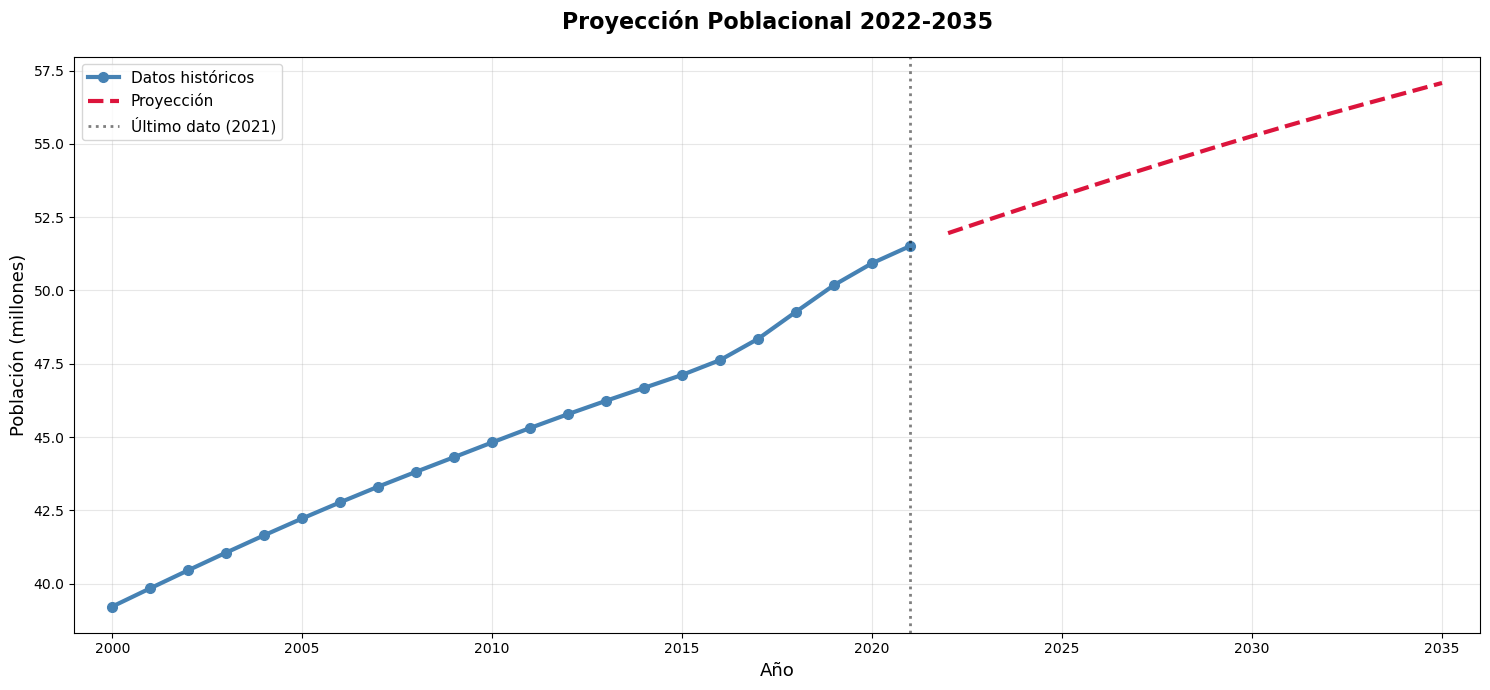

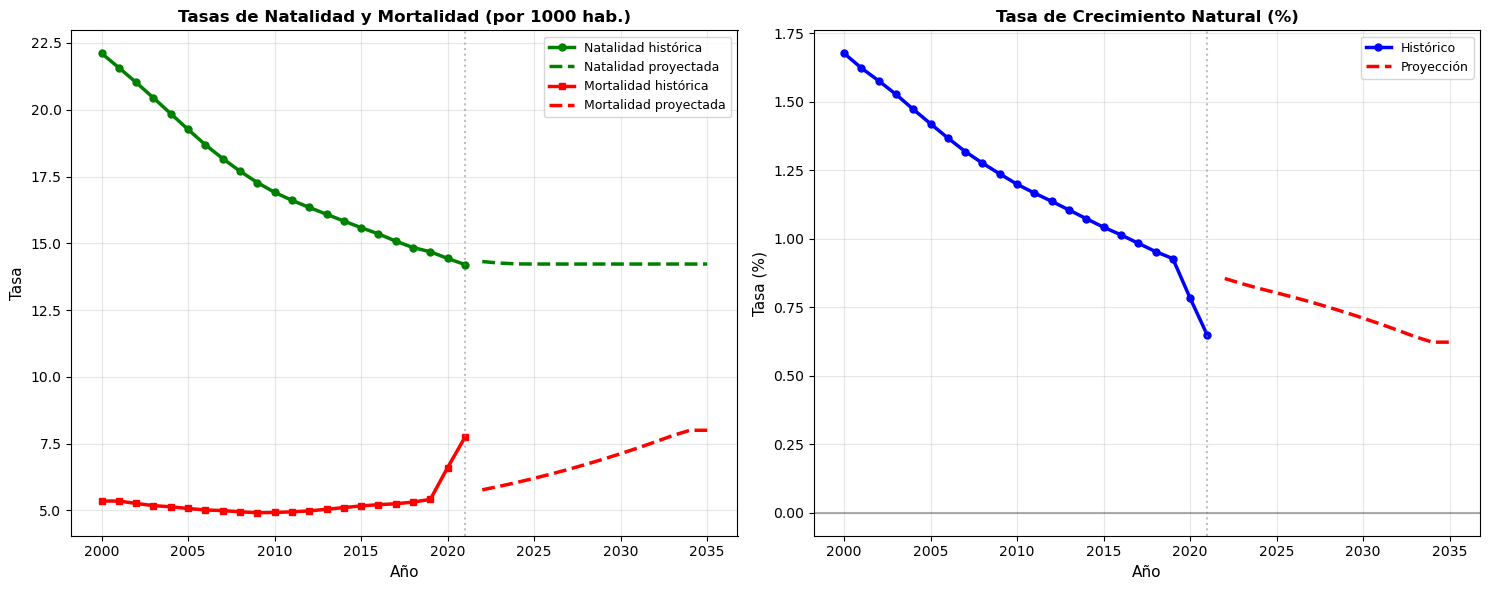

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================
# MODELO DEMOGRÁFICO SIMPLIFICADO
# Solo Población: Crecimiento = (Nacimientos - Muertes) / 1000
# ============================================

DB_HOST = "localhost"
DB_DATABASE = "population_collapse"
DB_USER = "root"
DB_PASSWORD = "San@orca.1315"

connection = mysql.connector.connect(
    host=DB_HOST,
    database=DB_DATABASE,
    user=DB_USER,
    password=DB_PASSWORD
)

df_population = pd.read_sql("SELECT * FROM population", con=connection)
df_birth = pd.read_sql("SELECT * FROM birth_rate", con=connection)
df_fertility = pd.read_sql("SELECT * FROM fertility_rate", con=connection)
df_death = pd.read_sql("SELECT * FROM death_rate", con=connection)

country = "COL"
years = [col for col in df_population.columns if col.startswith("YR")]

# Extraer datos del país
country_pop = df_population[df_population["id"] == country].iloc[0]
country_birth_rate = df_birth[df_birth["id"] == country].iloc[0]
country_death_rate = df_death[df_death["id"] == country].iloc[0]

# Crear DataFrame consolidado
df_col = pd.DataFrame({
    "Year": [int(y.replace("YR", "")) for y in years],
    "Population": country_pop[years].values.astype(float),
    "BirthRate": country_birth_rate[years].values.astype(float),
    "DeathRate": country_death_rate[years].values.astype(float)
})

# Calcular tasa de crecimiento natural
df_col["Natural_Growth_Rate"] = (df_col["BirthRate"] - df_col["DeathRate"]) / 10

# Calcular crecimiento "normalizado" (sin COVID)
mortality_2019 = df_col[df_col["Year"] == 2019]["DeathRate"].values[0]

# ============================================
# PROYECCIÓN DE TASAS DEMOGRÁFICAS
# ============================================

years_array = df_col["Year"].values.reshape(-1, 1)
poly = PolynomialFeatures(degree=2)  
years_poly = poly.fit_transform(years_array)

# Modelos de tendencia
birth_model = LinearRegression().fit(years_poly, df_col["BirthRate"])

# Excluir años COVID para mortalidad
df_col_pre_covid = df_col[df_col["Year"] < 2020]
years_pre_covid = df_col_pre_covid["Year"].values.reshape(-1, 1)
years_poly_pre_covid = poly.fit_transform(years_pre_covid)
death_model = LinearRegression().fit(years_poly_pre_covid, df_col_pre_covid["DeathRate"])

# Calcular métricas de ajuste
r2_birth = r2_score(df_col["BirthRate"], birth_model.predict(years_poly))
r2_death = r2_score(df_col_pre_covid["DeathRate"], death_model.predict(years_poly_pre_covid))

# ============================================
# PROYECCIÓN POBLACIONAL (2022-2035)
# ============================================

last_year = int(df_col["Year"].iloc[-1])
last_pop = df_col["Population"].iloc[-1]
future_years = list(range(last_year + 1, 2036))

projections = []
current_pop = last_pop

for i, year in enumerate(future_years):
    year_poly = poly.transform([[year]])

    pred_birth = birth_model.predict(year_poly)[0]
    pred_death = death_model.predict(year_poly)[0]

    # Restricciones realistas
    pred_birth = np.clip(pred_birth, 10, 20)
    pred_death = np.clip(pred_death, 5, 8)

    # Imponer tendencia decreciente
    if i > 0:
        pred_birth = min(pred_birth, projections[-1]["BirthRate"])

    # Calcular crecimiento natural
    natural_growth = (pred_birth - pred_death) / 10

    # Calcular población futura
    next_pop = current_pop * (1 + natural_growth / 100)

    projections.append({
        "Year": year,
        "Population": next_pop,
        "BirthRate": pred_birth,
        "DeathRate": pred_death,
        "Natural_Growth": natural_growth
    })

    current_pop = next_pop

df_future = pd.DataFrame(projections)

# ============================================
# MÉTRICAS DE VALIDACIÓN
# ============================================

# Métricas de calidad del ajuste
birth_predictions = birth_model.predict(years_poly)
death_predictions_full = death_model.predict(poly.transform(df_col["Year"].values.reshape(-1, 1)))

mae_birth = mean_absolute_error(df_col["BirthRate"], birth_predictions)
rmse_birth = np.sqrt(mean_squared_error(df_col["BirthRate"], birth_predictions))
mae_death = mean_absolute_error(df_col_pre_covid["DeathRate"], death_model.predict(years_poly_pre_covid))
rmse_death = np.sqrt(mean_squared_error(df_col_pre_covid["DeathRate"], death_model.predict(years_poly_pre_covid)))

print("MÉTRICAS DE VALIDACIÓN")
print("="*50)
print("Natalidad:")
print(f"R²:   {r2_birth:.4f}")
print(f"MAE:  {mae_birth:.4f}")
print(f"RMSE: {rmse_birth:.4f}")

print("\nMortalidad (2002-2019):")
print(f"R²:   {r2_death:.4f}")
print(f"MAE:  {mae_death:.4f}")
print(f"RMSE: {rmse_death:.4f}")

# ============================================
# PROYECCIONES CLAVE
# ============================================

print("\nPROYECCIONES DE POBLACIÓN")
print("="*50)
for target_year in [2025, 2030, 2035]:
    idx = df_future[df_future["Year"] == target_year].index[0]
    print(f"\nAño {target_year}:")
    print(f"Población estimada:     {df_future.loc[idx, 'Population']:,.0f}")
    print(f"Cambio desde 2021:     {((df_future.loc[idx, 'Population'] / last_pop - 1) * 100):.2f}%")
    print(f"Tasa de crecimiento:   {df_future.loc[idx, 'Natural_Growth']:.2f}%")

# ============================================
# VISUALIZACIONES
# ============================================

# Gráfico 1: Proyección poblacional
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_col["Year"], df_col["Population"] / 1e6,
        marker="o", linewidth=3, label="Datos históricos",
        color="steelblue", markersize=7)

ax.plot(df_future["Year"], df_future["Population"] / 1e6,
        linewidth=3, label="Proyección",
        color="crimson", linestyle="--")

ax.axvline(x=last_year, color="black", linestyle=":", linewidth=2,
           label=f"Último dato ({last_year})", alpha=0.5)

ax.set_title("Proyección Poblacional 2022-2035",
             fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Año", fontsize=13)
ax.set_ylabel("Población (millones)", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(df_col["Year"].min() - 1, df_future["Year"].max() + 1)

plt.tight_layout()
plt.show()

# Gráfico 2: Componentes demográficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(df_col["Year"], df_col["BirthRate"],
             marker="o", linewidth=2.5, label="Natalidad histórica",
             color="green", markersize=5)
axes[0].plot(df_future["Year"], df_future["BirthRate"],
             linewidth=2.5, linestyle="--", label="Natalidad proyectada", color="green")

axes[0].plot(df_col["Year"], df_col["DeathRate"],
             marker="s", linewidth=2.5, label="Mortalidad histórica",
             color="red", markersize=5)
axes[0].plot(df_future["Year"], df_future["DeathRate"],
             linewidth=2.5, linestyle="--", label="Mortalidad proyectada", color="red")

axes[0].axvline(x=last_year, color="gray", linestyle=":", alpha=0.5)
axes[0].set_title("Tasas de Natalidad y Mortalidad (por 1000 hab.)",
                  fontweight="bold", fontsize=12)
axes[0].set_xlabel("Año", fontsize=11)
axes[0].set_ylabel("Tasa", fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_col["Year"], df_col["Natural_Growth_Rate"],
             marker="o", linewidth=2.5, label="Histórico",
             color="blue", markersize=5)
axes[1].plot(df_future["Year"], df_future["Natural_Growth"],
             linewidth=2.5, linestyle="--", label="Proyección", color="red")

axes[1].axhline(y=0, color="black", linewidth=1.5, linestyle="-", alpha=0.3)
axes[1].axvline(x=last_year, color="gray", linestyle=":", alpha=0.5)
axes[1].set_title("Tasa de Crecimiento Natural (%)",
                  fontweight="bold", fontsize=12)
axes[1].set_xlabel("Año", fontsize=11)
axes[1].set_ylabel("Tasa (%)", fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os

# Crear directorio para los modelos si no existe
models_dir = 'modelo'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Guardar solo el modelo de proyección de población (birth_model)
model_path = os.path.join(models_dir, 'model.joblib')
joblib.dump(birth_model, model_path)

Modelo de proyección de población guardado exitosamente en el directorio 'modelos_entrenados'
